In [153]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
spark = SparkSession.builder.appName('K-Means').getOrCreate()

In [154]:
Uber_df = spark.read.csv('D:/UberApril14.csv', inferSchema = True, header = True)

In [155]:
Uber_df.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)



In [156]:
Uber_df.where(Uber_df['Lat'].isNull()).count()

0

In [157]:
Uber_df.where(Uber_df['Lon'].isNull()).count()

0

In [158]:
Uber_df.where(Uber_df['Base'].isNull()).count()

0

In [159]:
Uber_df.show(10,False)

+----------------+-------+--------+------+
|Date/Time       |Lat    |Lon     |Base  |
+----------------+-------+--------+------+
|4/1/2014 0:11:00|40.769 |-73.9549|B02512|
|4/1/2014 0:17:00|40.7267|-74.0345|B02512|
|4/1/2014 0:21:00|40.7316|-73.9873|B02512|
|4/1/2014 0:28:00|40.7588|-73.9776|B02512|
|4/1/2014 0:33:00|40.7594|-73.9722|B02512|
|4/1/2014 0:33:00|40.7383|-74.0403|B02512|
|4/1/2014 0:39:00|40.7223|-73.9887|B02512|
|4/1/2014 0:45:00|40.762 |-73.979 |B02512|
|4/1/2014 0:55:00|40.7524|-73.996 |B02512|
|4/1/2014 1:01:00|40.7575|-73.9846|B02512|
+----------------+-------+--------+------+
only showing top 10 rows



#### Shape of the data contained in the UberApril14.CSV

In [160]:
print(Uber_df.count(), len(Uber_df.columns))

564516 4


In [161]:
Uber_df.groupBy('Base').count().show()

+------+------+
|  Base| count|
+------+------+
|B02512| 35536|
|B02598|183263|
|B02682|227808|
|B02617|108001|
|B02764|  9908|
+------+------+



The company 'B02682	- Schmecken' has the highest number of trips among all others with 'B02598 - Hinter LLC' being the next highest. These are the companies that dominate in terms of percentage share of the trips

In [162]:
Uber_df.columns

['Date/Time', 'Lat', 'Lon', 'Base']

In [163]:
Uber_df.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)



For clustering, we need only numeric data types. As we can see above, Data/Time is of String datatypes. We are only going to work with Lat, Lon columns which doesn't need any transformations

Feature Engineering 

In [164]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [165]:
input_cols = ['Lat', 'Lon']

In [166]:
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol = 'features')

In [167]:
final_data_df = vec_assembler.transform(Uber_df)

In [168]:
final_data_df.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)
 |-- features: vector (nullable = true)



In [169]:
final_data_df.show(10,False)

+----------------+-------+--------+------+------------------+
|Date/Time       |Lat    |Lon     |Base  |features          |
+----------------+-------+--------+------+------------------+
|4/1/2014 0:11:00|40.769 |-73.9549|B02512|[40.769,-73.9549] |
|4/1/2014 0:17:00|40.7267|-74.0345|B02512|[40.7267,-74.0345]|
|4/1/2014 0:21:00|40.7316|-73.9873|B02512|[40.7316,-73.9873]|
|4/1/2014 0:28:00|40.7588|-73.9776|B02512|[40.7588,-73.9776]|
|4/1/2014 0:33:00|40.7594|-73.9722|B02512|[40.7594,-73.9722]|
|4/1/2014 0:33:00|40.7383|-74.0403|B02512|[40.7383,-74.0403]|
|4/1/2014 0:39:00|40.7223|-73.9887|B02512|[40.7223,-73.9887]|
|4/1/2014 0:45:00|40.762 |-73.979 |B02512|[40.762,-73.979]  |
|4/1/2014 0:55:00|40.7524|-73.996 |B02512|[40.7524,-73.996] |
|4/1/2014 1:01:00|40.7575|-73.9846|B02512|[40.7575,-73.9846]|
+----------------+-------+--------+------+------------------+
only showing top 10 rows



#### To train and then test the model, split the data from UberApril14 into training and test datasets using a 75/25 split. L

In [170]:
features_training_df, features_test_df = final_data_df.randomSplit([0.75,0.25])

In [171]:
print(Uber_training_df.count())

423068


In [172]:
print(Uber_test_df.count())

141448


In [173]:
Uber_training_df.groupBy('Base').count().show()

+------+------+
|  Base| count|
+------+------+
|B02512| 26750|
|B02598|137161|
|B02682|170649|
|B02617| 81014|
|B02764|  7494|
+------+------+



In [174]:
Uber_test_df.groupBy('Base').count().show()

+------+-----+
|  Base|count|
+------+-----+
|B02512| 8786|
|B02598|46102|
|B02682|57159|
|B02617|26987|
|B02764| 2414|
+------+-----+



The company 'B02682	- Schmecken' has the highest number of trips among all others with 'B02598 - Hinter LLC' being the next highest. These are the companies that dominate in terms of percentage share of the trips in both the training and test datasets. They do reppresent the overall data

#### Build and train KMeans Clustering model. 

K-Means Clustering Algorithm

In [175]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#generate elbow chart
#generate k-means object

error = []
for k in range(2,10):  #generattes sse value for all clusters.. generate plot and look at optimal number of clusters we need
    kmeans = KMeans(featuresCol = 'features', k = k).setSeed(1)
    model = kmeans.fit(Uber_training_df)
    intra_cluster_distance = model.computeCost(Uber_training_df)  #computecost generates sum of squared errors
    error.append(intra_cluster_distance)
    

In [176]:
#using this data, we're gonna plot elbow curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

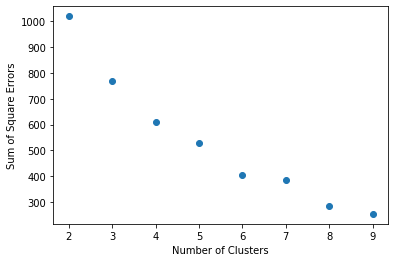

In [177]:
cluster_number = range(2, 10)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Square Errors')
plt.scatter(cluster_number, error)
plt.show()

#### From the scatter plot, we can say that elbow is occuring at 6th cluster, so we may have to start with cluster 6. That is K= 6


In [178]:
error = []
for k in range(2,10):  #generates sse value for all clusters.. generate plot and look at optimal number of clusters we need
    kmeans = KMeans(featuresCol = 'features', k = k).setSeed(1)
    #create model; training model using whole dataset
    model = kmeans.fit(Uber_training_df)
    predictions = model.transform(Uber_training_df)
    
    intra_cluster_distance = model.computeCost(Uber_training_df)  #computecost generates sum of squared errors
    error.append(intra_cluster_distance)
    
    evaluatorObj = ClusteringEvaluator()
    
    silhouette_coeff = evaluatorObj.evaluate(predictions)
    
    print("With K = {}".format(k))
    print("Sum of Squared error = " + str(intra_cluster_distance))
    print('Silhouette Coefficient :  ' + str(silhouette_coeff))
    print('--'*20)

With K = 2
Sum of Squared error = 1019.1650599317743
Silhouette Coefficient :  0.8826540728551335
----------------------------------------
With K = 3
Sum of Squared error = 770.5333639631318
Silhouette Coefficient :  0.4800718658191749
----------------------------------------
With K = 4
Sum of Squared error = 610.1840041642847
Silhouette Coefficient :  0.5359484756046211
----------------------------------------
With K = 5
Sum of Squared error = 527.8679581911551
Silhouette Coefficient :  0.5548701415676924
----------------------------------------
With K = 6
Sum of Squared error = 403.0267029438621
Silhouette Coefficient :  0.5640326055415588
----------------------------------------
With K = 7
Sum of Squared error = 384.0154718077757
Silhouette Coefficient :  0.5660410555459136
----------------------------------------
With K = 8
Sum of Squared error = 285.7999282119555
Silhouette Coefficient :  0.6338486327441958
----------------------------------------
With K = 9
Sum of Squared error =

variance decreases as  number of cluster increases. So we need to look at which is the most trusted or better way to cluster. 

Considering 5,6,7 clusters ie., n-1, n, n+1 clusters..


With K = 5
Sum of Squared error = 527.8679581911551
Silhouette Coefficient :  0.5548701415676924

With K = 6
Sum of Squared error = 403.0267029438621
Silhouette Coefficient :  0.5640326055415588

With K = 7
Sum of Squared error = 384.0154718077757
Silhouette Coefficient :  0.5660410555459136

From above.. we can say that low SSE and high Silhoutte are for the cluster 7 amongst clusters 5,6 and 7

In [179]:
kmeans = KMeans(featuresCol = 'features', k = 7).setSeed(1)
#create model; training model using whole dataset
model = kmeans.fit(Uber_training_df)
#figuring out which cluster we assigned
predictions = model.transform(Uber_training_df)
predictions.columns

['Date/Time', 'Lat', 'Lon', 'Base', 'features', 'prediction']

In [180]:
predictions.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|203887|
|         6|   688|
|         3|  3659|
|         5| 10804|
|         4|187856|
|         2|   489|
|         0| 15685|
+----------+------+



In [181]:
predictions.groupBy('prediction','Base').count().show()

+----------+------+-----+
|prediction|  Base|count|
+----------+------+-----+
|         1|B02512|11081|
|         3|B02682| 1392|
|         4|B02598|60768|
|         5|B02682| 4438|
|         2|B02512|   33|
|         1|B02682|82108|
|         6|B02617|  132|
|         5|B02764|  166|
|         3|B02764|  111|
|         1|B02617|40442|
|         2|B02598|  193|
|         1|B02764| 3703|
|         6|B02682|  252|
|         0|B02682| 6279|
|         6|B02764|   18|
|         0|B02617| 3152|
|         0|B02512| 1015|
|         3|B02617|  704|
|         5|B02512|  535|
|         3|B02512|  517|
+----------+------+-----+
only showing top 20 rows



In [182]:
pandas_df = predictions.toPandas()
pandas_df.sample(5)

,Date/Time,Lat,Lon,Base,features,prediction
97583,4/4/2014 19:43:00,40.7299,-74.0038,B02598,"[40.7299, -74.0038]",1
181240,4/26/2014 17:08:00,40.7653,-73.9755,B02598,"[40.7653, -73.9755]",4
174486,4/25/2014 22:01:00,40.7770,-73.9865,B02598,"[40.777, -73.9865]",4
27269,4/15/2014 11:17:00,40.7459,-74.0054,B02598,"[40.7459, -74.0054]",1
8016,4/10/2014 3:58:00,40.7321,-74.0024,B02598,"[40.7321, -74.0024]",1


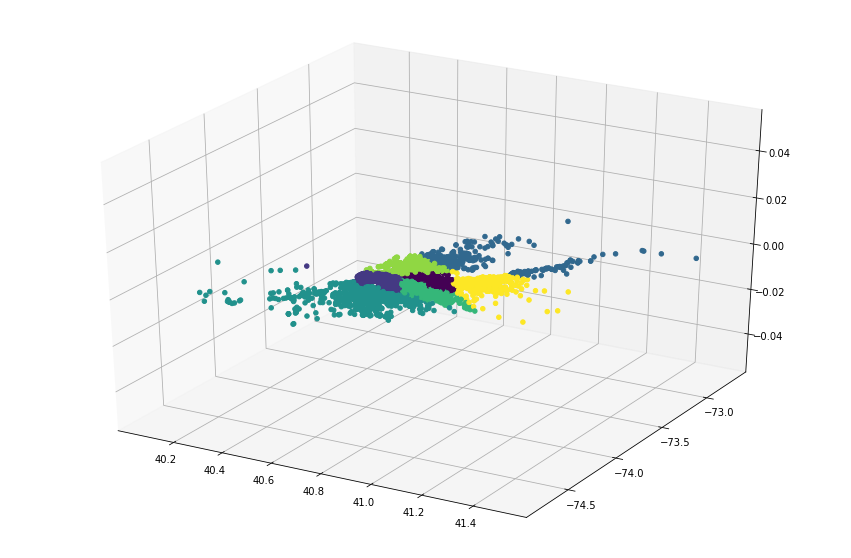

In [183]:
from mpl_toolkits.mplot3d import Axes3D
cluster_visualisation = plt.figure(figsize = (15,10)).gca(projection = '3d')
#3-D graph
cluster_visualisation.scatter(pandas_df.Lat, pandas_df.Lon, c = pandas_df.prediction, depthshade = False)

Trying with k= 6 clusters

In [102]:
kmeans = KMeans(featuresCol = 'features', k = 6).setSeed(1)
#create model; training model using whole dataset
model = kmeans.fit(Uber_training_df)
#figuring out which cluster we assigned
predictions = model.transform(Uber_training_df)
predictions.columns
#print(k)

['Date/Time', 'Lat', 'Lon', 'Base', 'features', 'prediction']

In [103]:
predictions.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1| 15154|
|         3| 10643|
|         5|171562|
|         4| 44943|
|         2|   745|
|         0|180483|
+----------+------+



In [104]:
predictions.groupBy('prediction','Base').count().show()

+----------+------+-----+
|prediction|  Base|count|
+----------+------+-----+
|         1|B02512|  966|
|         3|B02682| 4325|
|         4|B02598|15396|
|         5|B02682|69684|
|         2|B02512|   49|
|         1|B02682| 6061|
|         5|B02764| 2845|
|         3|B02764|  160|
|         1|B02617| 3121|
|         2|B02598|  258|
|         1|B02764|  237|
|         0|B02682|72674|
|         0|B02617|35127|
|         0|B02512|11212|
|         3|B02617| 2161|
|         5|B02512|12403|
|         3|B02512|  538|
|         2|B02682|  302|
|         5|B02598|55513|
|         2|B02764|   14|
+----------+------+-----+
only showing top 20 rows



In [105]:
pandas_df = predictions.toPandas()
pandas_df.sample(5)

,Date/Time,Lat,Lon,Base,features,prediction
164339,4/24/2014 19:36:00,40.7649,-73.9805,B02598,"[40.7649, -73.9805]",5
141895,4/16/2014 16:17:00,40.7513,-74.0051,B02617,"[40.7513, -74.0051]",0
56790,4/2/2014 21:26:00,40.7699,-73.8644,B02598,"[40.7699, -73.8644]",1
44447,4/18/2014 11:38:00,40.7114,-74.0055,B02512,"[40.7114, -74.0055]",0
299519,4/19/2014 12:18:00,40.7562,-73.9789,B02682,"[40.7562, -73.9789]",5


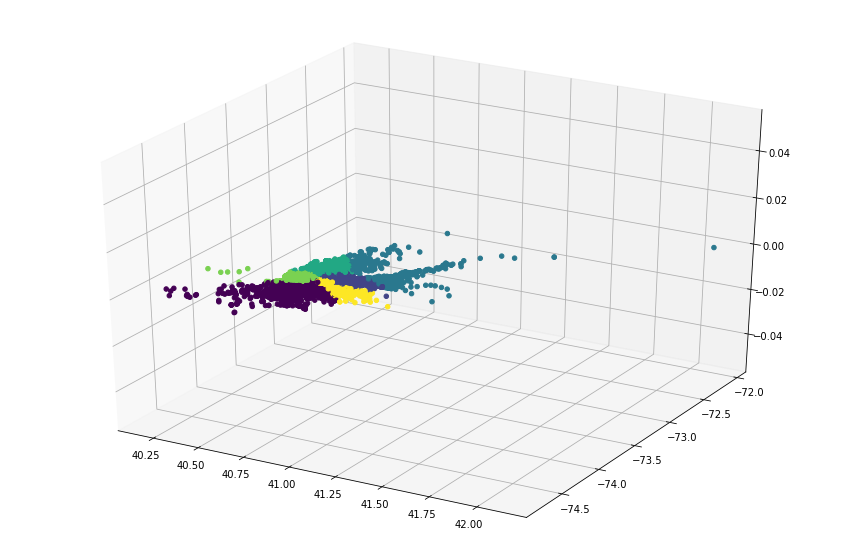

In [106]:
from mpl_toolkits.mplot3d import Axes3D
cluster_visualisation = plt.figure(figsize = (15,10)).gca(projection = '3d')
#3-D graph
cluster_visualisation.scatter(pandas_df.Lat, pandas_df.Lon, c = pandas_df.prediction, depthshade = False)

On the basis of SSE and Silhouette coefficient, we could select the cluster 7 as the best model.

#### Using the best trained model from above step, test the performance of the model against the test dataset.

Testing the performance of model against test dataset with k=7

In [109]:
kmeans = KMeans(featuresCol = 'features', k = 7).setSeed(1)
#create model; training model using whole dataset
model = kmeans.fit(Uber_test_df)
#figuring out which cluster we assigned
predictions = model.transform(Uber_test_df)

evaluatorObj = ClusteringEvaluator()
silhouette_coeff = evaluatorObj.evaluate(predictions)
print('Silhouette Coefficient:  ' + str(silhouette_coeff))

intra_cluster_distance = model.computeCost(Uber_test_df)  #computecost generates sum of squared errors
error.append(intra_cluster_distance)
print("Sum of Squared error = " + str(intra_cluster_distance))

Silhouette Coefficient:  0.6301399526193081
Sum of Squared error = 102.43076260655684


In [184]:
Uber_df.groupBy('Base').count().show()

+------+------+
|  Base| count|
+------+------+
|B02512| 35536|
|B02598|183263|
|B02682|227808|
|B02617|108001|
|B02764|  9908|
+------+------+



In [185]:
Uber_test_df.groupBy('Base').count().show()

+------+-----+
|  Base|count|
+------+-----+
|B02512| 8786|
|B02598|46102|
|B02682|57159|
|B02617|26987|
|B02764| 2414|
+------+-----+



The 7th cluster has low SSE and better Silhouette coefficient just like the trained model. We can say they're accurate. 

Other than Silhouette coefficient, metrics like Calinski-Harabasz Index, dunn index, Davies–Bouldin index can be used to measure performance of K means clustering. 
Higher the Dunn index value, better is the clustering.
Lower the DB index value, better is the clustering. 
I couldn't find metrics using pyspark's MLlib but did find other metrics using scikit learn!